In [1]:
import argparse
import importlib
import random
import torch
import os
import time
import numpy as np
import pprint as pprint

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import matplotlib
_utils_pp = pprint.PrettyPrinter()
import torch

# Utils

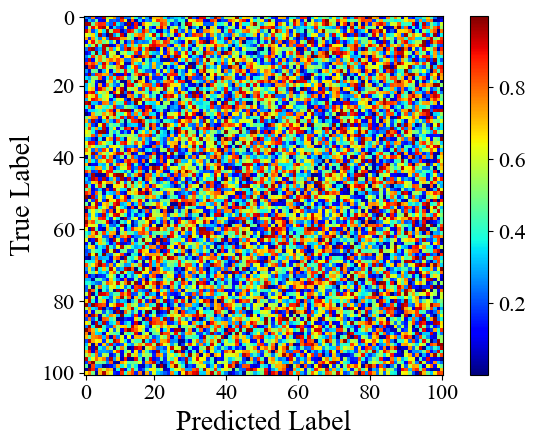

In [2]:
def pprint(x):
    _utils_pp.pprint(x)


def set_seed(seed):
    if seed == 0:
        print(' random seed')
        torch.backends.cudnn.benchmark = True
    else:
        print('manual seed:', seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def set_gpu(args):
    gpu_list = [int(x) for x in args.gpu.split(',')]
    print('use gpu:', gpu_list)
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return gpu_list.__len__()


def ensure_path(path):
    if os.path.exists(path):
        pass
    else:
        print('create folder:', path)
        os.makedirs(path)

# 求平均值
class Averager():

    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v


class Timer():

    def __init__(self):
        self.o = time.time()

    def measure(self, p=1):
        x = (time.time() - self.o) / p
        x = int(x)
        if x >= 3600:
            return '{:.1f}h'.format(x / 3600)
        if x >= 60:
            return '{}m'.format(round(x / 60))
        return '{}s'.format(x)

# 计算准确率
def count_acc(logits, label):
    pred = torch.argmax(logits, dim=1)
    if torch.cuda.is_available():
        return (pred == label).type(torch.cuda.FloatTensor).mean().item()
    else:
        return (pred == label).type(torch.FloatTensor).mean().item()

# 计算前k类的准确率
def count_acc_topk(x,y,k=5):
    _,maxk = torch.topk(x,k,dim=-1)
    total = y.size(0)
    test_labels = y.view(-1,1) 
    #top1=(test_labels == maxk[:,0:1]).sum().item()
    topk=(test_labels == maxk).sum().item()
    return float(topk/total)

def count_acc_taskIL(logits, label,args):
    basenum=args.base_class
    incrementnum=(args.num_classes-args.base_class)/args.way
    for i in range(len(label)):
        currentlabel=label[i]
        if currentlabel<basenum:
            logits[i,basenum:]=-1e9
        else:
            space=int((currentlabel-basenum)/args.way)
            low=basenum+space*args.way
            high=low+args.way
            logits[i,:low]=-1e9
            logits[i,high:]=-1e9

    pred = torch.argmax(logits, dim=1)
    if torch.cuda.is_available():
        return (pred == label).type(torch.cuda.FloatTensor).mean().item()
    else:
        return (pred == label).type(torch.FloatTensor).mean().item()

def confmatrix(logits,label,filename):
    
    font={'family':'Times New Roman','size':18}
    matplotlib.rc('font',**font)
    matplotlib.rcParams.update({'font.family':'Times New Roman','font.size':18})
    plt.rcParams["font.family"]="Times New Roman"

    pred = torch.argmax(logits, dim=1)
    cm=confusion_matrix(label, pred,normalize='true')
    #print(cm)
    clss=len(cm)
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.imshow(cm,cmap=plt.cm.jet) 
    if clss<=100:
        plt.yticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
        plt.xticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
    elif clss<=200:
        plt.yticks([0,39,79,119,159,199],[0,40,80,120,160,200],fontsize=16)
        plt.xticks([0,39,79,119,159,199],[0,40,80,120,160,200],fontsize=16)
    else:
        plt.yticks([0,199,399,599,799,999],[0,200,400,600,800,1000],fontsize=16)
        plt.xticks([0,199,399,599,799,999],[0,200,400,600,800,1000],fontsize=16)

    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)
    plt.tight_layout()
    plt.savefig(filename+'.pdf',bbox_inches='tight')
    plt.close()

    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.imshow(cm,cmap=plt.cm.jet) 
    cbar = plt.colorbar(cax) # This line includes the color bar
    cbar.ax.tick_params(labelsize=16)
    if clss<=100:
        plt.yticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
        plt.xticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
    elif clss<=200:
        plt.yticks([0,39,79,119,159,199],[0,40,80,120,160,200],fontsize=16)
        plt.xticks([0,39,79,119,159,199],[0,40,80,120,160,200],fontsize=16)
    else:
        plt.yticks([0,199,399,599,799,999],[0,200,400,600,800,1000],fontsize=16)
        plt.xticks([0,199,399,599,799,999],[0,200,400,600,800,1000],fontsize=16)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)
    plt.tight_layout()
    plt.savefig(filename+'_cbar.pdf',bbox_inches='tight')
    plt.close()

    return cm


def dummy_matrix(mat,filename):
    font={'family':'Times New Roman','size':18}
    matplotlib.rc('font',**font)
    matplotlib.rcParams.update({'font.family':'Times New Roman','font.size':18})
    plt.rcParams["font.family"]="Times New Roman"

   
    cm=mat
    

    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.imshow(cm,cmap=plt.cm.jet) 
    cbar = plt.colorbar(cax) 
    cbar.ax.tick_params(labelsize=16)
    plt.yticks([0,19,39,59],[0,20,40,60],fontsize=16)
    plt.xticks([0,19,39],[0,20,40],fontsize=16)

    plt.xlabel('Virtual Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)
    plt.tight_layout()
    plt.savefig(filename+'.pdf',bbox_inches='tight')
    plt.close()

    print('transpose')
    cm=np.transpose(mat)
    

    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.imshow(cm,cmap=plt.cm.jet) 
    cbar = plt.colorbar(cax,shrink=0.7) 
    cbar.ax.tick_params(labelsize=16)
    plt.xticks([0,19,39,59],[0,20,40,60],fontsize=16)
    plt.yticks([0,19,39],[0,20,40],fontsize=16)

    plt.ylabel('Virtual Label',fontsize=20)
    plt.xlabel('True Label',fontsize=20)
    plt.tight_layout()
    plt.savefig(filename+'_2.pdf',bbox_inches='tight')
    return cm


def save_list_to_txt(name, input_list):
    f = open(name, mode='w')
    for item in input_list:
        f.write(str(item) + '\n')
    f.close()


if __name__=='__main__':

    font={'family':'Times New Roman','size':18}
    matplotlib.rc('font',**font)
    matplotlib.rcParams.update({'font.family':'Times New Roman','font.size':18})
    plt.rcParams["font.family"]="Times New Roman"

    cm=np.random.rand(100,100)
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    cax = ax.imshow(cm,cmap=plt.cm.jet) 
    plt.yticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
    plt.xticks([0,19,39,59,79,99],[0,20,40,60,80,100],fontsize=16)
    cbar = plt.colorbar(cax) # This line includes the color bar
    cbar.ax.tick_params(labelsize=16)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)
    plt.tight_layout()
    plt.show()
    plt.savefig('2.pdf',bbox_inches='tight')
    plt.close()

In [3]:
MODEL_DIR=None
DATA_DIR = 'data/'
PROJECT='limit'
# PROJECT='base'

In [4]:
def get_command_line_parser():
    parser = argparse.ArgumentParser()

    # about dataset and network
    parser.add_argument('-project', type=str, default=PROJECT)
    parser.add_argument('-dataset', type=str, default='cwru',
                        choices=['cwru', 'cub200', 'cifar100'])
    parser.add_argument('-dataroot', type=str, default=DATA_DIR)

    # about pre-training
    parser.add_argument('-epochs_base', type=int, default=1)
    parser.add_argument('-epochs_new', type=int, default=1)
    parser.add_argument('-lr_base', type=float, default=0.1)
    parser.add_argument('-lr_new', type=float, default=0.1)
    parser.add_argument('-schedule', type=str, default='Step',
                        choices=['Step', 'Milestone','Cosine'])
    parser.add_argument('-milestones', nargs='+', type=int, default=[60, 70])
    parser.add_argument('-step', type=int, default=20)
    parser.add_argument('-decay', type=float, default=0.0005)
    parser.add_argument('-momentum', type=float, default=0.9)
    parser.add_argument('-gamma', type=float, default=0.1)
    parser.add_argument('-temperature', type=float, default=16)
    parser.add_argument('-not_data_init', action='store_true', help='using average data embedding to init or not')

    parser.add_argument('-batch_size_base', type=int, default=128)
    parser.add_argument('-batch_size_new', type=int, default=0, help='set 0 will use all the availiable training image for new')
    parser.add_argument('-test_batch_size', type=int, default=100)
    parser.add_argument('-base_mode', type=str, default='ft_cos',
                        choices=['ft_dot', 'ft_cos']) # ft_dot means using linear classifier, ft_cos means using cosine classifier
    parser.add_argument('-new_mode', type=str, default='avg_cos',
                        choices=['ft_dot', 'ft_cos', 'avg_cos']) # ft_dot means using linear classifier, ft_cos means using cosine classifier, avg_cos means using average data embedding and cosine classifier

    # for episode learning
    parser.add_argument('-train_episode', type=int, default=50)  #表示在训练过程中将进行的训练轮次（episodes）的数量。在每个训练轮次中，模型会接收一组支持集和查询集的输入，以进行参数更新和学习
    parser.add_argument('-episode_shot', type=int, default=1) #表示每个训练轮次中所使用的支持集样本的数量（shot）
    parser.add_argument('-episode_way', type=int, default=15)#表示每个训练轮次中涉及的类别（way）的数量
    parser.add_argument('-episode_query', type=int, default=15)#表示每个训练轮次中将用于测试的查询样本的数量

    #for castle
    # parser.add_argument('-meta_class_way', type=int, default=10, help='total classes(including know and unknown) to sample in training process')
    # parser.add_argument('-meta_new_class', type=int, default=4)
    parser.add_argument('-num_tasks', type=int, default=256)  #: 表示在训练期间生成的任务数量 
    parser.add_argument('-sample_class', type=int, default=1) #表示在每个任务中抽取的类别数量（class）
    parser.add_argument('-sample_shot', type=int, default=1)#表示在每个类别中抽取的样本数量（shot）

    # for pretrain
    parser.add_argument('-balance', type=float, default=1.0)
    parser.add_argument('-balance_for_reg', type=float, default=1.0)
    parser.add_argument('-loss_iter', type=int, default=200)
    parser.add_argument('-alpha', type=float, default=2.0)

    parser.add_argument('-fuse', type=float, default=0.04)
    parser.add_argument('-topk', type=int, default=2)
    parser.add_argument('-prototype_momentum', type=float, default=0.99)
    parser.add_argument('-eta', type=float, default=0.5)

    #for feat+maml
    # parser.add_argument('-maml', type=int, default=0)
    #for multi_stage FG
    # parser.add_argument('-stage', type=int, default=1)
    
    # for finetune-methods and icarl
    # parser.add_argument('-tune_epoch', type=int, default=5)
    # parser.add_argument('-manyshot', type=int, default=100)
    # parser.add_argument('-exemplar_num', type=int, default=20)
    
    parser.add_argument('-lrg', type=float, default=0.1) #lr for graph attention network
    parser.add_argument('-low_shot', type=int, default=1)
    parser.add_argument('-low_way', type=int, default=15)
    # for ablation
    parser.add_argument('-shot_num', type=int, default=5)  # 指定在每个类别中用作支持样本的数量（shot）。例如，如果 -shot_num 设置为 5，则在每个类别中会选取 5 个样本用于模型的训练
    parser.add_argument('-start_session', type=int, default=0)
    parser.add_argument('-model_dir', type=str, default=MODEL_DIR, help='loading model parameter from a specific dir')
    parser.add_argument('-set_no_val', action='store_true', help='set validation using test set or no validation')
    # for training
    parser.add_argument('-gpu', default='0')
    parser.add_argument('-num_workers', type=int, default=0)
    parser.add_argument('-seed', type=int, default=1)
    parser.add_argument('-autoaug', type=int, default=1)

    return parser

In [5]:
parser = get_command_line_parser()
args = parser.parse_args([])
set_seed(args.seed)
print(vars(args))
args.num_gpu = set_gpu(args)
print(args.num_gpu)

manual seed: 1
{'project': 'limit', 'dataset': 'cwru', 'dataroot': 'data/', 'epochs_base': 1, 'epochs_new': 1, 'lr_base': 0.1, 'lr_new': 0.1, 'schedule': 'Step', 'milestones': [60, 70], 'step': 20, 'decay': 0.0005, 'momentum': 0.9, 'gamma': 0.1, 'temperature': 16, 'not_data_init': False, 'batch_size_base': 128, 'batch_size_new': 0, 'test_batch_size': 100, 'base_mode': 'ft_cos', 'new_mode': 'avg_cos', 'train_episode': 50, 'episode_shot': 1, 'episode_way': 15, 'episode_query': 15, 'num_tasks': 256, 'sample_class': 1, 'sample_shot': 1, 'balance': 1.0, 'balance_for_reg': 1.0, 'loss_iter': 200, 'alpha': 2.0, 'fuse': 0.04, 'topk': 2, 'prototype_momentum': 0.99, 'eta': 0.5, 'lrg': 0.1, 'low_shot': 1, 'low_way': 15, 'shot_num': 5, 'start_session': 0, 'model_dir': None, 'set_no_val': False, 'gpu': '0', 'num_workers': 0, 'seed': 1, 'autoaug': 1}
use gpu: [0]
1


In [6]:
trainer = importlib.import_module('models.%s.fscil_trainer' % (args.project)).FSCILTrainer(args)

random init params
*********WARNINGl: NO INIT MODEL**********


In [7]:
true, pre = trainer.train()

new classes for this session:
 [0 1 2 3]
Session 0, epo 0, lrc=0.1000,total loss=1.4014 query acc=0.2289
Self.current_way: 1
********A better model is found!!**********
Saving model to :checkpoint\cwru/limit/1SC-1Epo-16.00T-1Sshot0.00050Dec-0.90Mom-128Q_Lr1_0.100000-Lrg_0.10000-Step_20-Gam_0.10\session0_max_acc.pth
best epoch 0, best val acc=90.000
epoch:000,lr:0.1000,training_loss:1.40315,training_acc:0.23063,val_loss:1.53013,val_acc:0.90000
This epoch takes 34 seconds 
still need around 0.58 mins to finish
The test acc of base session=89.000
training session: [1]
Seen Acc: 0.89 Unseen ACC: 0.94
Saving model to :checkpoint\cwru/limit/1SC-1Epo-16.00T-1Sshot0.00050Dec-0.90Mom-128Q_Lr1_0.100000-Lrg_0.10000-Step_20-Gam_0.10\session1_max_acc.pth
  test acc=90.000
training session: [2]
Seen Acc: 0.89 Unseen ACC: 0.97
Saving model to :checkpoint\cwru/limit/1SC-1Epo-16.00T-1Sshot0.00050Dec-0.90Mom-128Q_Lr1_0.100000-Lrg_0.10000-Step_20-Gam_0.10\session2_max_acc.pth
  test acc=91.667
training s